C:\Users\Dell 3541\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():
C:\Users\Dell 3541\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


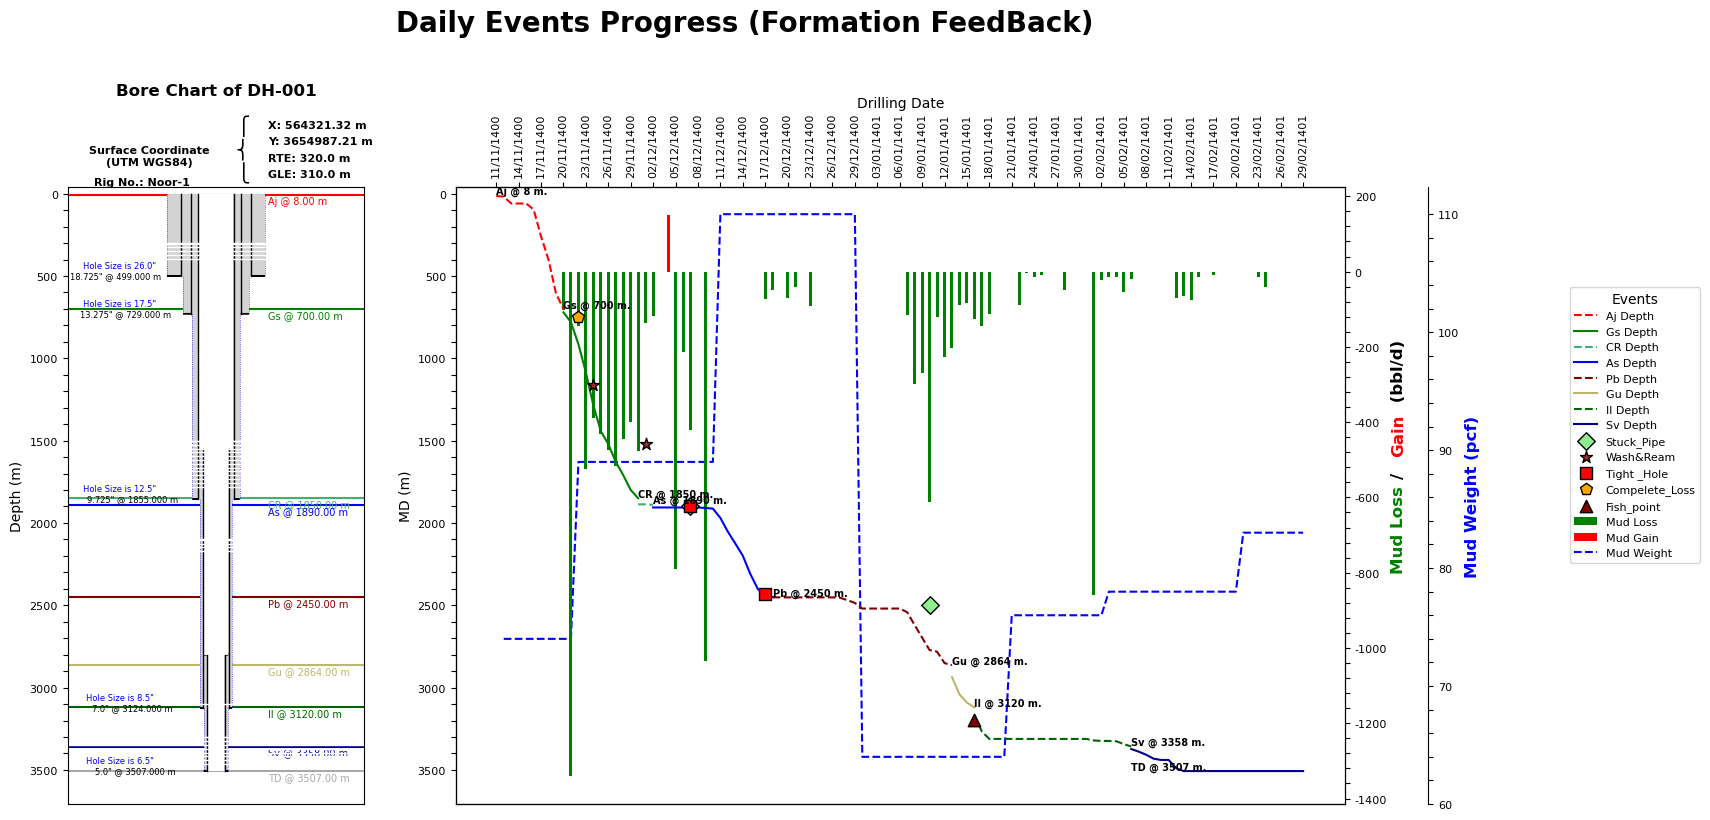

Plot saved as drilling_report.png, drilling_report.pdf


In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import matplotlib.patches as patches
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from PIL import Image
from matplotlib.offsetbox import TextArea, VPacker, AnchoredOffsetbox

excel_file = r"C:\Users\Dell 3541\OneDrive\Desktop\Well Symbol.xlsx"
well_sections = pd.read_excel(excel_file, sheet_name="well")
DDR = pd.read_excel(excel_file, sheet_name="Data")

well_Name = well_sections["Well_Name"].tolist()[0]
surface_coordinates = {
    "x": well_sections["X"].tolist()[0],
    "y": well_sections["Y"].tolist()[0],
    "RTE": well_sections["RTE"].tolist()[0],
    "GLE": well_sections["GLE"].tolist()[0],
    "Rig": well_sections["Rig"].tolist()[0]
}
hole_sizes = well_sections["Hole_Size (in)"].tolist()
hole_depths = well_sections["Hole_Depth (m)"].tolist()
casing_sizes = well_sections["Casing_Size (in)"].tolist()
casing_depths = well_sections["Casing_Depth (m)"].tolist()
is_liner = well_sections["Is_Liner (yes/no)"].tolist()
liner_lap_depths = well_sections["Liner_Lap_Depth (m)"].tolist()
perforation_issue = well_sections["perf_issue"].tolist()[0].lower()
Perforation_depths = well_sections[["perf_from" , "perf_to"]]

nan_indices = [i for i, x in enumerate(hole_sizes) if np.isnan(x)]
dfs = [
    pd.DataFrame(hole_sizes),
    pd.DataFrame(hole_depths),
    pd.DataFrame(casing_sizes),
    pd.DataFrame(casing_depths),
    pd.DataFrame(is_liner),
    pd.DataFrame(liner_lap_depths)
]
cleaned_dfs = [df.drop(index=nan_indices) for df in dfs]
hole_sizes, hole_depths, casing_sizes, casing_depths, is_liner, liner_lap_depths = cleaned_dfs

liner_sizes = []
for i in range(len(liner_lap_depths)):
    if pd.notna(liner_lap_depths.iloc[i, 0]):
        liner_sizes.append(casing_sizes.iloc[i, 0])
hole_sizes = hole_sizes.iloc[:, 0].tolist()
hole_depths = hole_depths.iloc[:, 0].tolist()
casing_sizes = casing_sizes.iloc[:, 0].tolist()
casing_depths = casing_depths.iloc[:, 0].tolist()
is_liner = is_liner.iloc[:, 0].tolist()
liner_lap_depths = liner_lap_depths.iloc[:, 0].tolist()

# Parse formation tops data
formation_names = well_sections["Formation_Name"].tolist()
formation_depths = well_sections["Depth (m)"].tolist()
formation_colors = well_sections["Color"].tolist()

# Define the total depth of the well
total_depth = max(hole_depths + formation_depths)

formation_names = well_sections["Formation_Name"].tolist()
formation_depths = well_sections["Depth (m)"].tolist()
formation_colors = well_sections["Color"].tolist()
exclude_columns = ['Date', 'Depth', 'Mud_Loss', 'Mud_Gain', 'Mud_Weight', 'categories', 'sym', 'color', 'symboles','TVD(m)']
columns_to_include = [col for col in DDR.columns if col not in exclude_columns]
symbol_mapping = DDR[['categories', 'sym']].dropna()
symbols = pd.DataFrame([symbol_mapping['sym'].values], columns=symbol_mapping['categories'].values)
colors_mapping = DDR[['categories', 'color']].dropna()
colors = pd.DataFrame([colors_mapping['color'].values], columns=colors_mapping['categories'].values)
event_data = {}
for column in columns_to_include:
    event_subset = DDR[['Date', column]].dropna()
    symbol = symbols.loc[0, column]
    color = colors.loc[0, column]
    event_data[column] = {
        'depths': event_subset[column].tolist(),
        'categories': event_subset['Date'].tolist(),
        'symbol': symbol,
        'color': color,
    }

horizontal_text = DDR['Date']
depths = DDR['Depth']
TVD = DDR['TVD(m)']
mud_loss = DDR['Mud_Loss']
mud_gain = DDR['Mud_Gain']
mud_weight = DDR['Mud_Weight']

def plot_1(ax):
    
    

    # Define the wellbore (vertical dashed lines)
    #fig, ax = plt.subplots(figsize=(6, 10))

    
    # Plotting logic
    casings = [i for i in casing_sizes if i not in liner_sizes]
    liners = [i for i in casing_sizes if i in liner_sizes]

    current_depth = 0
    # Plot each drilled hole section with the respective sizes (send them to the back)
    for i in range(len(hole_sizes)):
        # Draw a dashed line for each hole section only up to its own depth
        hole_diameter = hole_sizes[i] * 0.0254
        outer_left_x = 1 - hole_diameter / 2
        outer_right_x = 1 + hole_diameter / 2
        #ax.plot([outer_left_x, outer_left_x], [current_depth, hole_depths[i]], color='blue', linestyle='--')
        #ax.plot([outer_right_x, outer_right_x], [current_depth, hole_depths[i]], color='blue', linestyle='--')
        hole_diameter = hole_sizes[i] * 0.0254  # Convert inches to meters
        hole_left_x = 1 - hole_diameter / 2
        hole_right_x = 1 + hole_diameter / 2
        ann = patches.Rectangle((hole_left_x, 0), hole_diameter, hole_depths[i],
                                linewidth=0, facecolor='lightgrey', zorder=0)
        ax.add_patch(ann)
        ax.plot([outer_left_x, outer_left_x], [current_depth, hole_depths[i]], color='blue', linestyle=':', linewidth=0.5)
        ax.plot([outer_right_x, outer_right_x], [current_depth, hole_depths[i]], color='blue', linestyle=':', linewidth=0.5)
        # Update current depth to the depth of this hole
        current_depth = hole_depths[i]


    for i in range(len(casings)):
        # Shade the space between casing and hole with light grey (annulus)
        casing_diameter = casing_sizes[i] * 0.0254
        casing_left_x = 1 - casing_diameter / 2
        casing_right_x = 1 + casing_diameter / 2
        ann1 = patches.Rectangle((casing_left_x, 0), casing_diameter, casing_depths[i], linewidth=0, facecolor='lightgrey', zorder=0)
        ax.add_patch(ann1)

    # Now plot each casing section on top of the hole sections
    current_depth = 0
    for i in range(len(casing_sizes)):
        # If it's a liner, it doesn't extend to surface, but hangs at liner lap depth
        if is_liner[i] == 'yes':
            # Draw the line from the liner lap depth to the liner depth
            liner_lap_depth = liner_lap_depths[i]
            casing_depth = casing_depths[i]
            
            # Ensure the casing size for the liner is used correctly
            liner_diameter = casing_sizes[i] * 0.0254  # Convert inches to meters for liner
            
            # Draw the liner as a vertical line from liner lap to liner depth
            casing_left_x = 1 - liner_diameter / 2
            casing_right_x = 1 + liner_diameter / 2
            ax.plot([casing_left_x, casing_left_x], [liner_lap_depth, casing_depth], color='black', linestyle='-', linewidth=1)
            ax.plot([casing_right_x, casing_right_x], [liner_lap_depth, casing_depth], color='black', linestyle='-', linewidth=1)
    
            # Add liner lap symbol (casing shoe) at liner lap depth
            triangle_base = (hole_sizes[i] * 0.0254 - liner_diameter) / 2  # Base length of the triangles
            left_triangle = np.array([
                [casing_left_x, liner_lap_depth],
                [casing_left_x - triangle_base, liner_lap_depth],
                [casing_left_x, liner_lap_depth - triangle_base]
            ])
            right_triangle = np.array([
                [casing_right_x, liner_lap_depth],
                [casing_right_x + triangle_base, liner_lap_depth],
                [casing_right_x, liner_lap_depth - triangle_base]
            ])
    
            left_triangle1 = np.array([
                [casing_left_x, casing_depths[i]],  # Top of the casing
                [casing_left_x - triangle_base, casing_depths[i]],  # Left point of the triangle base
                [casing_left_x, casing_depths[i] - triangle_base]  # Bottom point of the triangle
            ])
            # Define vertices of the right triangle
            right_triangle1 = np.array([
                [casing_right_x, casing_depths[i]],  # Top of the casing
                [casing_right_x + triangle_base, casing_depths[i]],  # Right point of the triangle base
                [casing_right_x, casing_depths[i] - triangle_base]  # Bottom point of the triangle
            ])
            ax.add_patch(patches.Polygon(left_triangle, closed=True, color='black'))
            ax.add_patch(patches.Polygon(right_triangle, closed=True, color='black'))
            ax.add_patch(patches.Polygon(left_triangle1, closed=True, color='black'))
            ax.add_patch(patches.Polygon(right_triangle1, closed=True, color='black'))
    
        else:
            # Draw casing with two vertical lines extending to the surface
            casing_diameter = casing_sizes[i] * 0.0254  # Convert inches to meters
            casing_left_x = 1 - casing_diameter / 2
            casing_right_x = 1 + casing_diameter / 2
    
            triangle_base = (hole_sizes[i] * 0.0254 - casing_diameter) / 2  # Base length of the triangles
            # Define vertices of the left triangle
            left_triangle = np.array([
                [casing_left_x, casing_depths[i]],  # Top of the casing
                [casing_left_x - triangle_base, casing_depths[i]],  # Left point of the triangle base
                [casing_left_x, casing_depths[i] - triangle_base]  # Bottom point of the triangle
            ])
            # Define vertices of the right triangle
            right_triangle = np.array([
                [casing_right_x, casing_depths[i]],  # Top of the casing
                [casing_right_x + triangle_base, casing_depths[i]],  # Right point of the triangle base
                [casing_right_x, casing_depths[i] - triangle_base]  # Bottom point of the triangle
            ])
        
            # Add the triangles to the plot
            ax.add_patch(patches.Polygon(left_triangle, closed=True, color='black'))
            ax.add_patch(patches.Polygon(right_triangle, closed=True, color='black'))
    
            ax.plot([casing_left_x, casing_left_x], [0, casing_depths[i]], color='black', linestyle='-', linewidth=1)
            ax.plot([casing_right_x, casing_right_x], [0, casing_depths[i]], color='black', linestyle='-', linewidth=1)
    
        # Add text annotations for casing sizes and depths
        casing_text = f"{casing_sizes[i]}\" @ {casing_depths[i]:.3f} m"
        ax.text(casing_left_x - 0.75, casing_depths[i], casing_text, color='black', fontsize=6, verticalalignment='center')
    
        # Update current depth to the depth of this casing
        current_depth = casing_depths[i]
    
        # Add casing size annotation 50 meters above hole size depth
        ax.text(0.35, hole_depths[i] - 50, f"Hole Size is {hole_sizes[i]}\"", color='blue', fontsize=6, horizontalalignment='center')
    
    # Now do not fill the space inside the well (inside casing), leave it transparent (no color)
    current_depth = 0
    for i in range(len(casing_sizes)):
        casing_diameter = casing_sizes[i] * 0.0254  # Convert inches to meters
        casing_left_x = 1 - casing_diameter / 2
        casing_right_x = 1 + casing_diameter / 2
        # Remove the white filling for the well interior
        # We leave the space inside the casing without any fill
        
        # Update current depth to the depth of this casing
        current_depth = casing_depths[i]
    
    for i in range(len(formation_names)):
        ax.axhline(y=formation_depths[i], color=formation_colors[i], linestyle='-', linewidth=1.5, zorder=-1)
        formation_label = f"{formation_names[i]} @ {formation_depths[i]:.2f} m"
        ax.text(1.35, formation_depths[i] + 35, formation_label, color=formation_colors[i], fontsize=7, verticalalignment='center', zorder=0)
    
    # Set plot limits and labels
    ax.set_ylim(total_depth + 200, 0-40)
    ax.set_xlim(0, 2)
    #ax.set_xlabel('Well Schematic')
    ax.set_ylabel('Depth (m)')
    ax.text(1, -600, f"Bore Chart of {well_Name}", fontsize=12, ha='center', weight='bold')

    # Add surface coordinates and elevation information below the title
    # Adjust the coordinates (1.5, -50) to place them below the title as needed
    ax.text(.55, -175, f"Surface Coordinate\n(UTM WGS84)", color='black', fontsize=8, ha='center',fontweight='bold')
    ax.text(1.35, -400, f"X: {surface_coordinates['x']} m", color='black', fontsize=8, ha='left',fontweight='bold')
    ax.text(1.35, -300, f"Y: {surface_coordinates['y']} m", color='black', fontsize=8, ha='left',fontweight='bold')
    ax.text(1.35, -200, f"RTE: {surface_coordinates['RTE']} m", color='black', fontsize=8, ha='left',fontweight='bold')
    ax.text(1.35, -100, f"GLE: {surface_coordinates['GLE']} m", color='black', fontsize=8, ha='left',fontweight='bold') 
    ax.text(1.18, -275,"⎧\n⎨\n⎩", color='black', fontsize=13, ha='center', va='center',linespacing = 1.12)
    ax.text(0.18, -50, f"Rig No.: {surface_coordinates['Rig']} ", color='black', fontsize=8, ha='left',fontweight='bold')
    

    
    epsilon = 0.01  # You can adjust this value as needed for a small offset
    
    # Get the last casing size and liner lap depth
    if len(hole_sizes) == len([size for size in casing_sizes if pd.notna(size)]):
        last_casing_diameter = casing_sizes[-1] * 0.0254
        surface_left_x = 1 - (last_casing_diameter / 2) + epsilon
        surface_right_x = 1 + (last_casing_diameter / 2) - epsilon
        rectangle1_height = hole_depths[-1] - epsilon
        rectw = patches.Rectangle((surface_left_x, 0), 
                                  surface_right_x - surface_left_x, 
                                  rectangle1_height, 
                                  linewidth=0, facecolor='white', zorder=1)
    else:
        diameter = hole_sizes[-1] * 0.0254
        surface_left_x = 1 - (diameter / 2) + epsilon
        surface_right_x = 1 + (diameter / 2) - epsilon
        rectangle2_height = hole_depths[-1] - epsilon
        rectangle1_height = hole_depths[-1] - epsilon
        rectw = patches.Rectangle((surface_left_x, 0), 
                                  surface_right_x - surface_left_x, 
                                  rectangle1_height, 
                                  linewidth=0, facecolor='white', zorder=1)
        
    ax.add_patch(rectw)
    
    rectw_dict = {}  # Initialize a dictionary to store rectangles
    
    if any(is_liner):
        rectw_dict = {}
        for i in reversed(range(len(liner_lap_depths))):  # Loop in reverse order
            if is_liner[i]:
                diameter = casing_sizes[i-1] * 0.0254
                surface_left_x = 1 - (diameter / 2) + epsilon
                surface_right_x = 1 + (diameter / 2) - epsilon
                rectangle2_height = liner_lap_depths[i] - epsilon
                
                # Create the rectangle and store it in the dictionary
                rectw = patches.Rectangle(
                    (surface_left_x, 0), 
                    surface_right_x - surface_left_x, 
                    rectangle2_height, 
                    linewidth=0, facecolor='white', zorder=1
                )
                rectw_dict[f"rectw_{i}"] = rectw  # Store rectangle with dynamic key
        for rectw in rectw_dict.values():
            ax.add_patch(rectw)

    if perforation_issue == 'yes':
        for i in range(len(Perforation_depths)):
            perf_from = float(Perforation_depths.loc[i, "perf_from"])
            perf_to = float(Perforation_depths.loc[i, "perf_to"])
            current_y = perf_from
            dash_length = 3
            gap_length = 20
            ax.plot([-1 * max(hole_sizes)/2,  max(hole_sizes)/2], [perf_from, perf_from], color='white', linewidth = 1, linestyle='-')
            while current_y + dash_length <= perf_to:
                ax.plot([-1 * max(hole_sizes)/2,  max(hole_sizes)/2], [current_y + dash_length, current_y + dash_length], color='white', linewidth = 1 ,linestyle='-')
                current_y += dash_length + gap_length
                
    
    ax.set_xticks([])  # Remove tick marks
    ax.set_xticklabels([])  # Remove tick labels
    # Assuming `ax` is your main axis object
    main_ticks = np.arange(0, total_depth + 1, 500)  # Main ticks every 500 meters (example)
    additional_ticks = np.arange(0, total_depth + 1, 100)  # Additional ticks every 100 meters (example)
    
    # Set main ticks and their labels
    ax.set_yticks(main_ticks)
    ax.set_yticklabels([f"{tick:.0f}" for tick in main_ticks], fontsize=8)
    
    # Add additional ticks without labels
    all_ticks = np.unique(np.concatenate([main_ticks, additional_ticks]))
    ax.set_yticks(all_ticks)  # Combine all ticks
    ax.set_yticklabels([f"{tick:.0f}" if tick in main_ticks else "" for tick in all_ticks], fontsize=8)
        


# Function for the second plot (Code 2)
def plot_2(ax):
    
    

    # Use the provided axis object
    ax1 = ax

    ax1.set_zorder(3)
    ax1.patch.set_visible(False)  # Make ax1's background transparent
    
    ax1.set_xlabel('Drilling Date')
    ax1.set_ylabel('MD (m)', color='black')    

    ax2 = ax1.twinx()   

    ax2.set_zorder(2)
    ax2.patch.set_visible(False)

    def multicolor_ylabel(ax, list_of_strings, list_of_colors, axis='x', anchorpad=0, **kw):
        if axis == 'y' or axis == 'both':
            boxes = [TextArea(text, textprops=dict(color=color, ha='left', va='bottom', rotation=90, **kw))
                     for text, color in zip(list_of_strings[::-1], list_of_colors)]
            ybox = VPacker(children=boxes, align="center", pad=0, sep=5)
            anchored_ybox = AnchoredOffsetbox(loc=3, child=ybox, pad=anchorpad, frameon=False,
                                              bbox_to_anchor=(1.052, 0.37),
                                              bbox_transform=ax.transAxes, borderpad=0.)
            ax.add_artist(anchored_ybox)

    multicolor_ylabel(ax2, 
                      ['Mud Loss', '/', 'Gain', ' (bbl/d)'], 
                      ['black', 'red', 'black', 'green'], 
                      axis='y', size=12, weight='bold')
    ax2.bar(horizontal_text, mud_loss, width=0.4, color='green', label='Mud Loss',zorder = -1)
    ax2.bar(horizontal_text, mud_gain, width=0.4, color='red', label='Mud Gain',zorder = -1)
    
    data_min = min([value for value in mud_loss if not np.isnan(value)])
    data_max = max([value for value in mud_gain if not np.isnan(value)])
    maximum1 = max (abs(data_min) , abs(data_max))
    initial_tick_interval = maximum1 / 8
    nice_values = [10, 50, 100, 200, 300, 400, 500]
    perfect_tick_interval = min([value for value in nice_values if value >= initial_tick_interval])
    firstv = 0
    main_ticks1 = [0]
    while firstv >= data_min:
        main_ticks1.append(firstv)
        firstv -= perfect_tick_interval
    main_ticks1.append(main_ticks1[-1] - perfect_tick_interval)

    firstv = 0
    additional_ticks1 = [0]
    while firstv >= data_min:
        additional_ticks1.append(firstv)
        firstv -= perfect_tick_interval/5
    additional_ticks1.append(additional_ticks1[-1] - perfect_tick_interval/5)

    firstv = 0
    main_ticks2 = [0]
    while firstv <= data_max:
        main_ticks1.append(firstv)
        firstv += perfect_tick_interval
    main_ticks2.append(main_ticks2[-1] + perfect_tick_interval)

    firstv = 0
    additional_ticks2 = [0]
    while firstv <= data_max:
        additional_ticks2.append(firstv)
        firstv += perfect_tick_interval/5
    additional_ticks2.append(additional_ticks2[-1] + perfect_tick_interval/5)
    
    ax3 = ax1.twinx()
# Set zorder for ax3 (lowest priority)
    ax3.set_zorder(1)
    ax3.patch.set_visible(False)
    
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('Mud Weight (pcf)', color='blue', fontsize=12, fontweight='bold')
    ax3.plot(horizontal_text, mud_weight, color='blue', linestyle='--', label='Mud Weight')
    
    for i in range(len(formation_names)):
        formation = formation_names[i]
        top_formation = formation_depths[i]

        if i + 1 < len(formation_names):
            progress_drilling = DDR[
                (DDR['Depth'] <= formation_depths[i + 1]) &
                (DDR['Depth'] >= formation_depths[i])
            ][['Date', 'Depth']]

            if not progress_drilling.empty and progress_drilling['Depth'].iloc[-1] < formation_depths[i + 1]:
                next_date = DDR[DDR['Depth'] > progress_drilling['Depth'].iloc[-1]]['Date'].iloc[0]

                if pd.notna(next_date):
                    new_row = {'Date': next_date, 'Depth': formation_depths[i + 1]}
                    progress_drilling = pd.concat([progress_drilling, pd.DataFrame([new_row])], ignore_index=True)

            Horizontal_Date = progress_drilling['Date']
            Vertical_depth = progress_drilling['Depth']
            color_line = formation_colors[i]
            line_style = '--' if i % 2 == 0 else '-'
            ax1.plot(Horizontal_Date, Vertical_depth, color=color_line, linestyle=line_style, label=f'{formation} Depth')

        ax1.annotate(
            f"{formation} @ {top_formation} m.",
            xy=(Horizontal_Date.iloc[0], top_formation),
            xytext=(Horizontal_Date.iloc[0], top_formation - 10),
            textcoords='data',
            fontsize=7,
            color="black",
            fontweight='bold',
            zorder = 100
        )

    
    ax1.invert_yaxis()
    ax1.xaxis.set_label_position('top')
    ax1.xaxis.tick_top()

    ticks = np.arange(0, len(horizontal_text), 3)
    ax1.set_xticks(ticks)
    ax1.set_xticklabels(horizontal_text[ticks], rotation=90, fontsize=8)

    ax1.set_ylim(total_depth + 200, 0-40)

    # ax4 = ax1.twinx()
    # ax4.spines['left'].set_position(('outward', 60))
    # ax4.set_ylabel('TVD (m)', color='black')
    # ax4.yaxis.set_label_position('left')  # Move the label to the left
    # ax4.yaxis.set_ticks_position('left')  # Move the ticks to the left
    # ax4.set_zorder(4)  # Ensure ax4 is above ax1
    # ax4.patch.set_visible(False)
    # ax4.invert_yaxis()
    # total_TVD = float(TVD.iloc[-1])
    
    for event, data in event_data.items():
        depths = data['depths']
        categories = data['categories']
        symbol = data['symbol']
        color = data['color']
        for depth, category in zip(depths, categories):
            x = horizontal_text[horizontal_text == category].index[0]
            ax1.scatter(x, depth, label=event, marker=symbol, s=80, color=color, edgecolor='black', zorder = 10)

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles3, labels3 = ax3.get_legend_handles_labels()
    # handles4, labels4 = ax4.get_legend_handles_labels()

    all_handles = handles1 + handles2 + handles3 #+ handles4
    all_labels = labels1 + labels2 + labels3 #+ labels4 

    unique = dict(zip(all_labels, all_handles))
    all_handles = list(unique.values())
    all_labels = list(unique.keys())

    fig.legend(all_handles, all_labels, loc='center left', bbox_to_anchor=(1.05, 0.5), 
               title='Events', fontsize=8, title_fontsize=10, borderaxespad=0)

    # Assuming `ax` is your main axis object
    main_ticks = np.arange(0, total_depth + 1, 500)  # Main ticks every 500 meters (example)
    additional_ticks = np.arange(0, total_depth + 1, 100)  # Additional ticks every 100 meters (example)
    
    # Set main ticks and their labels
    ax1.set_yticks(main_ticks)
    ax1.set_yticklabels([f"{tick:.0f}" for tick in main_ticks], fontsize=8)
    
    # Add additional ticks without labels
    all_ticks = np.unique(np.concatenate([main_ticks, additional_ticks]))
    ax1.set_yticks(all_ticks)  # Combine all ticks
    ax1.set_yticklabels([f"{tick:.0f}" if tick in main_ticks else "" for tick in all_ticks], fontsize=8)
    
    main_ticks1_2 = np.unique(np.concatenate([main_ticks1, main_ticks2]))
    ax2.set_yticks(main_ticks1_2)
    ax2.set_yticklabels([f"{tick:.0f}" for tick in main_ticks1_2], fontsize=8)
    
    all_ticks1 = np.unique(np.concatenate([main_ticks1, additional_ticks1,main_ticks2, additional_ticks2]))
    ax2.set_yticks(all_ticks1)  # Combine all ticks    
    ax2.set_yticklabels([f"{tick:.0f}" if tick in main_ticks1_2 else "" for tick in all_ticks1], fontsize=8)

    mud_weight_min = np.nanmin(mud_weight)  # Minimum value (ignoring NaN)
    mud_weight_max = np.nanmax(mud_weight)  # Maximum value (ignoring NaN)
    
    # Calculate the first perfect divisible value by 10 below min and above max
    main_tick_min = np.floor(mud_weight_min / 10) * 10  # First divisible by 10 below min
    main_tick_max = np.ceil(mud_weight_max / 10) * 10   # First divisible by 10 above max
    
    # Generate main ticks (every 10 units)
    main_ticks2 = np.arange(main_tick_min, main_tick_max + 10, 10)
    ax3.set_yticks(main_ticks2)
    ax3.set_yticklabels([f"{tick:.0f}" for tick in main_ticks2], fontsize=8)
    
    # Generate additional ticks (every 2 units)
    additional_ticks2 = np.arange(main_tick_min, main_tick_max + 2, 2)
    all_ticks2 = np.unique(np.concatenate([main_ticks2, additional_ticks2]))
    ax3.set_yticks(all_ticks2)  # Combine all ticks    
    ax3.set_yticklabels([f"{tick:.0f}" if tick in main_ticks2 else "" for tick in all_ticks2], fontsize=8)


    # depth_values = DDR['Depth'].values
    # tvd_values = DDR['TVD(m)'].values
    
    # # Define main ticks (e.g., 0, 250, 500, ...)
    # main_ticks3 = np.arange(0, max(depth_values) + 1, 250)
    
    # # Define sub ticks (e.g., 50, 100, 150, ...)
    # sub_ticks3 = np.arange(0, max(depth_values) + 1, 50)
    
    # # Combine main and sub ticks
    # all_ticks3 = np.unique(np.concatenate([main_ticks3, sub_ticks3]))
    
    # # Set ticks on ax4
    # ax4.set_yticks(all_ticks3)
    
    # # Find the corresponding TVD values for the ticks in all_ticks3
    # tvd_labels = []
    # for depth in all_ticks3:
    #     # Find the index of the closest Depth value
    #     idx = np.abs(depth_values - depth).argmin()
    #     # Get the corresponding TVD value
    #     tvd_labels.append(f"{tvd_values[idx]:.0f}" if depth in main_ticks3 else "")
    
    # Set labels only for main ticks (leave sub ticks unlabeled)
    # ax4.set_yticklabels(tvd_labels, fontsize=8)
    #ax4.set_ylim(total_TVD + 200, 0-40)
    # # Assuming `ax` is your main axis object
    # total_TVD = float(TVD.iloc[-1])
    # main_ticks3 = np.arange(0, total_TVD + 1, 200)  # Main ticks every 500 meters (example)
    # additional_ticks3 = np.arange(0, total_TVD + 1, 40)  # Additional ticks every 100 meters (example)
    
    # # Set main ticks and their labels
    # ax4.set_yticks(main_ticks3)
    # ax4.set_yticklabels([f"{tick:.0f}" for tick in main_ticks3], fontsize=8)
    
    # # Add additional ticks without labels
    # additional_ticks3 = np.arange(0, total_TVD + 1, 100)
    # all_ticks3 = np.unique(np.concatenate([main_ticks3, additional_ticks3]))
    # ax4.set_yticks(all_ticks3)  # Combine all ticks
    # ax4.set_yticklabels([f"{tick:.0f}" if tick in main_ticks3 else "" for tick in all_ticks3], fontsize=8)    
    
    
    

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [1, 3]})  # 1 row, 2 columns

# Generate both plots
plot_1(ax1)  # First subplot
plot_2(ax2)  # Second subplot


fig.suptitle('Daily Events Progress (Formation FeedBack)', fontsize=20, fontweight='bold', y=1.02)
# Load the logo image
logo = Image.open('C:/Users/Dell 3541/OneDrive/Desktop/nioc.png')  # Replace with your logo file path
#logo = logo.resize((175, 175))
# Add the logo to the figure
fig.figimage(logo, xo = fig.bbox.xmax + 8500, yo = fig.bbox.ymax + 5000, alpha = 0.8, zorder=10)

# Adjust layout for better visualization
fig.tight_layout()

# Show the combined figure
plt.show()

# Save the plot to a high-resolution image or A3-sized PDF
output_filename = "drilling_report"
output_formats = ["png", "pdf"]  # Specify desired formats

# Adjust figure size for A3 (landscape)
fig.set_size_inches(16.5, 11.7)  # A3 size in inches (width x height)

# Export the plot in specified formats
for fmt in output_formats:
    fig.savefig(f"{output_filename}.{fmt}", format=fmt, dpi=600, bbox_inches="tight")

print(f"Plot saved as {', '.join([f'{output_filename}.{fmt}' for fmt in output_formats])}")